# Setup

In [1]:
import os
FOLDERNAME = os.getcwd()
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append(FOLDERNAME)

# Change work directory to the current one
import os
os.chdir(FOLDERNAME)
print(f'Current folder changed to {os.getcwd()}')

Current folder changed to c:\Users\user\Desktop\zhuyi\PTI\camus-hands-on-main\camus_vae


In [2]:
import numpy as np
from tqdm import tqdm
import logging
from pathlib import Path
from tqdm.auto import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

c:\Users\user\Desktop\zhuyi\PTI\env_pytorch\pytorch1.12-cuda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from lib import utils, net, data, visu, debug
from lib.train import train_and_evaluate
from lib.evaluate import predict

In [4]:
from lib.autoencoder import VariationalAutoencoder2d

# Configuration

In [5]:
class Params():
    def __init__(self,params_dict):
        self.__dict__.update(params_dict)

    def update(self,params_dict):
        self.__dict__.update(params_dict)

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

params_dict = {
               'IMG_SIZE' : 64,

               'device' : device,
               'dtype' : torch.float32,

               'batch_size' : 64,
               }
args = Params(params_dict)

assert args.IMG_SIZE == 64, "the model only supports 64x64 pixel images"
print(f'device : {args.device}')

device : cuda


## Load CAMUS dataset

In [6]:
data_dir = '../dataset/segmentation/'
train_datalist = data.create_datalist(data_dir, 'train')
val_datalist = data.create_datalist(data_dir, 'valid')
test_datalist = data.create_datalist(data_dir, 'test')

print(f'training sample number   : {len(train_datalist)}')
print(f'validation sample number : {len(val_datalist)}')
print(f'testing sample number    : {len(test_datalist)}')

ix = np.random.choice(len(train_datalist))
print(train_datalist[ix])

training sample number   : 800
validation sample number : 100
testing sample number    : 100
{'image': '../dataset/segmentation/train\\images\\patient0177_4CH_ES.png', 'label': '../dataset/segmentation/train\\labels\\patient0177_4CH_ES_gt.png'}


## Image augmentation

In [7]:
from monai.data import CacheDataset

# Get transforms for training, validation and testing
trans_train, trans_val, trans_test = data.get_load_and_augmentation_transforms(args.IMG_SIZE)

# Use CacheDataset to accelerate training and validation
train_ds = CacheDataset(data=train_datalist, transform=trans_train, cache_rate=1.0)
val_ds = CacheDataset(data=val_datalist, transform=trans_val, cache_rate=1.0)
test_ds = CacheDataset(data=test_datalist, transform=trans_test, cache_rate=1.0)


    Transforms to load data : 
    -----------------------------------
    LoadImaged
    EnsureChannelFirstd
    Resized
    NormalizeIntensityd
    

    Transforms for image augmentation : 
    -----------------------------------
    RandRotated
    RandZoomd
    RandFlipd
    RandGaussianNoised
    RandGaussianSmoothd
    RandScaleIntensityd
    RandAdjustContrastd
    


Loading dataset: 100%|██████████| 100/100 [00:00<00:00, 182.33it/s]


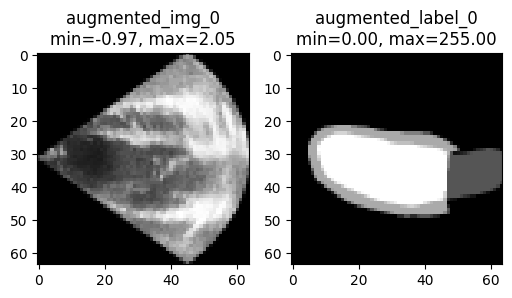

In [11]:
debug.test_img_aug(ix=0, dataset=train_ds, s=3)

In [12]:
train_loader = DataLoader(dataset=train_ds, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=args.batch_size,
                        shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=args.batch_size,
                         shuffle=False)

# Model

In [13]:
model_dir = './experiments/20231211-vae_kdl_trial2'
os.makedirs(model_dir, exist_ok=True)

In [14]:
d = {
    # model
    'input_shape' : (1, args.IMG_SIZE, args.IMG_SIZE),
    'blocks' : 3,
    'init_channels' : 64,
    'latent_dim' : 256,
    'activation' : "ELU",
    'use_batchnorm' : True,

    # experiment
    'learning_rate': 1e-3,
    'kld_weight' :   1e-3,
    'weight_decay' : 6.32e-5,

    'num_epochs': 200,

    'model_dir' : model_dir,
    'show_imgs_every' : 5,
    'save_checkpoint' : False,
    'save_best' : False,
  
     }
args.update(d)

for k,v in args.__dict__.items():
    print(f'{k:20} : {v}')

IMG_SIZE             : 64
device               : cuda
dtype                : torch.float32
batch_size           : 64
input_shape          : (1, 64, 64)
blocks               : 3
init_channels        : 64
latent_dim           : 256
activation           : ELU
use_batchnorm        : True
learning_rate        : 0.001
kld_weight           : 0.001
weight_decay         : 6.32e-05
num_epochs           : 200
model_dir            : ./experiments/20231211-vae_kdl_trial2
show_imgs_every      : 5
save_checkpoint      : False
save_best            : False


In [15]:
from torchinfo import summary

model = VariationalAutoencoder2d(args.input_shape, args.blocks, args.init_channels,
                                 args.latent_dim, activation=args.activation,
                                 use_batchnorm=args.use_batchnorm)
model = model.to(device=args.device)

# # Print the summary of the network
summary_kwargs = dict(
   col_names = ["input_size", "output_size", "num_params"],
   depth = 3,
   verbose = 0,
)
input_shape = (10, 1, args.IMG_SIZE, args.IMG_SIZE)
summary(model, input_shape, **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
VariationalAutoencoder2d                      [10, 1, 64, 64]           [10, 256]                 --
├─Encoder2d: 1-1                              [10, 1, 64, 64]           [10, 256]                 --
│    └─Sequential: 2-1                        [10, 1, 64, 64]           [10, 64, 4, 4]            --
│    │    └─Sequential: 3-1                   [10, 1, 64, 64]           [10, 64, 32, 32]          768
│    │    └─Sequential: 3-2                   [10, 64, 32, 32]          [10, 64, 32, 32]          37,056
│    │    └─Sequential: 3-3                   [10, 64, 32, 32]          [10, 128, 16, 16]         74,112
│    │    └─Sequential: 3-4                   [10, 128, 16, 16]         [10, 128, 16, 16]         147,840
│    │    └─Sequential: 3-5                   [10, 128, 16, 16]         [10, 256, 8, 8]           295,680
│    │    └─Sequential: 3-6                   [10, 256, 8, 8]      

# Training

In [ ]:
# Set the random seed for reproducible experiments
torch.manual_seed(230)
if args.device == torch.device('cuda'):
    torch.cuda.manual_seed(230)

# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Define the model and optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate,
                       weight_decay=args.weight_decay)
# Train the model
logging.info("Starting training for {} epoch(s)".format(args.num_epochs))
history = train_and_evaluate(model, train_loader, val_loader, optimizer, net.loss_fn,
                             net.metrics, args, restore_file=None)

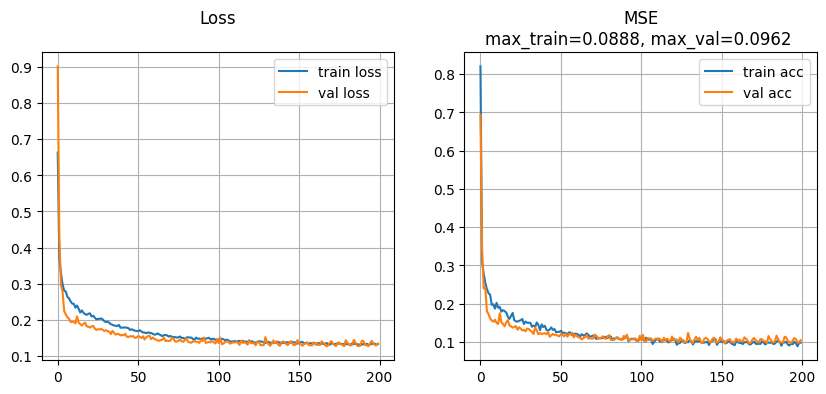

In [92]:
epoch_lim = args.num_epochs

tr_loss, val_loss, tr_mse, val_mse = history['train_loss'],history['val_loss'],\
                                     history['train_mse'],history['val_mse']
factor = 0.5
rows, cols = 1, 2
fig, ax = plt.subplots(rows,cols,figsize=(cols*factor*10, rows*factor*8))
ax[0].plot(tr_loss[:epoch_lim],label='train loss')
ax[0].plot(val_loss[:epoch_lim],label='val loss')
ax[0].legend()
ax[0].grid()
title = 'Loss\n'
ax[0].set_title(title)

ax[1].plot(tr_mse,label='train acc')
ax[1].plot(val_mse,label='val acc')
ax[1].legend()
ax[1].grid()
title = 'MSE\n'
title += f'max_train={min(tr_mse):.4f}, max_val={min(val_mse):.4f} '
ax[1].set_title(title)
plt.show()

## Save the model (and load)

In [93]:
model_path = os.path.join(model_dir, '20231211-vae-kdlAdjust_2.pth')
assert not os.path.exists(model_path),'model already exists, you really want to overwrite it?'
torch.save(model.state_dict(), model_path)


# Load the model

In [16]:
# Load the saved model
model_path = "./experiments/20231210-vae_second_try/20231210-vae-mse003.pth"
# model_path = os.path.join("./experiments/20231211-vae_kdl_trial2", '20231211-vae-kdlAdjust_2.pth')

model = VariationalAutoencoder2d(args.input_shape, args.blocks, args.init_channels,
                                 args.latent_dim, activation=args.activation,
                                 use_batchnorm=args.use_batchnorm)
model = model.to(device=args.device)
model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

# Inference CAMUS

In [17]:
loader = train_loader

##############################################################################

out_dict_camus = predict(loader, model, args)

avg_mu_camus = np.mean(out_dict_camus['all_mu'], axis=0)
print(f'avg_mu_camus shape  : {avg_mu_camus.shape}')

all_var_camus = np.exp(out_dict_camus['all_logvar'])
avg_var_camus = np.mean(all_var_camus, axis=0)
print(f'avg_var_camus shape : {avg_var_camus.shape}')


print('\n average l1 error')
print(f'Average l1 error of mu_bar  : {np.abs(avg_mu_camus- 0).mean()}')
print(f'Average l1 error of var_bar : {np.abs(avg_var_camus- 1).mean()}')

100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


avg_mu_camus shape  : (256,)
avg_var_camus shape : (256,)

 average l1 error
Average l1 error of mu_bar  : 0.1018599271774292
Average l1 error of var_bar : 0.9308542013168335


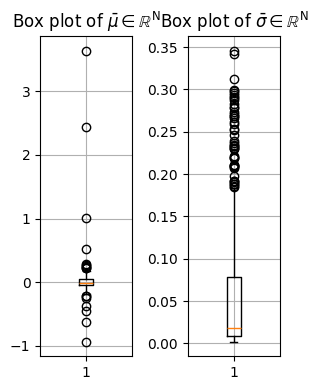

In [48]:
fig, ax = plt.subplots(1,2, figsize=(1.5*2,4*1))
ax = ax.ravel()

ax[0].boxplot(avg_mu_camus)
ax[0].grid()
ax[0].set_title(r'Box plot of $\bar{\mu}\in \mathbb{R}^{\text{N}}$')

ax[1].boxplot(avg_var_camus)
ax[1].grid()
ax[1].set_title(r'Box plot of $\bar{\sigma}\in \mathbb{R}^{\text{N}}$')

fig.tight_layout()
plt.show()

## Show reconstruction

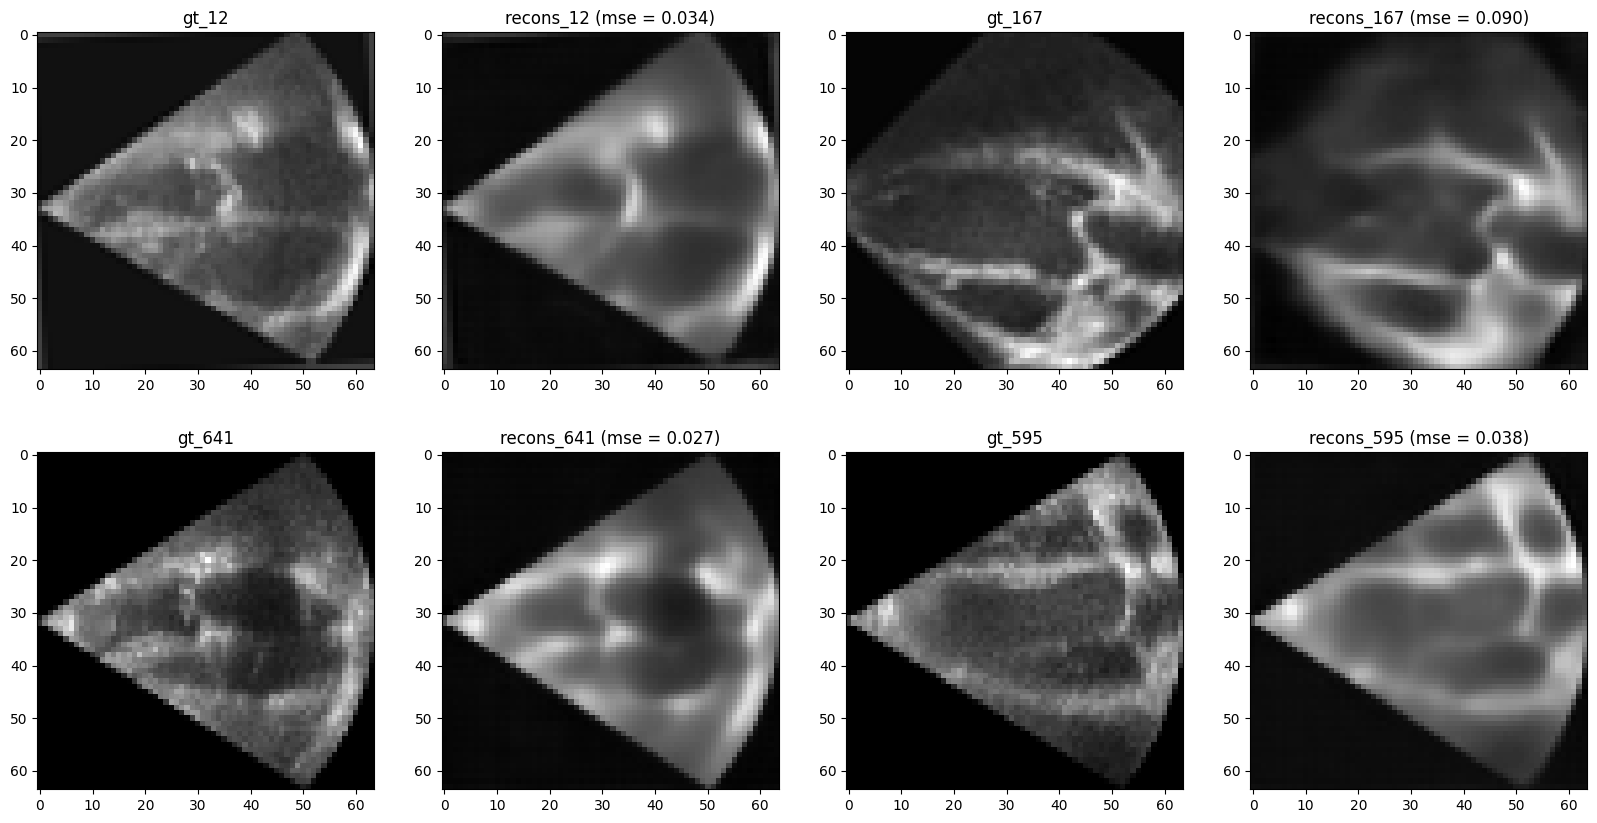

In [49]:
visu.show_reconstruction(out_dict_camus['all_imgs'], out_dict_camus['all_x_hat'], nb_picked=4, 
                    random_show=True, save=False)

## Show latent space

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\user\Desktop\zhuyi\PTI\env_pytorch\pytorch1.12-cuda\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


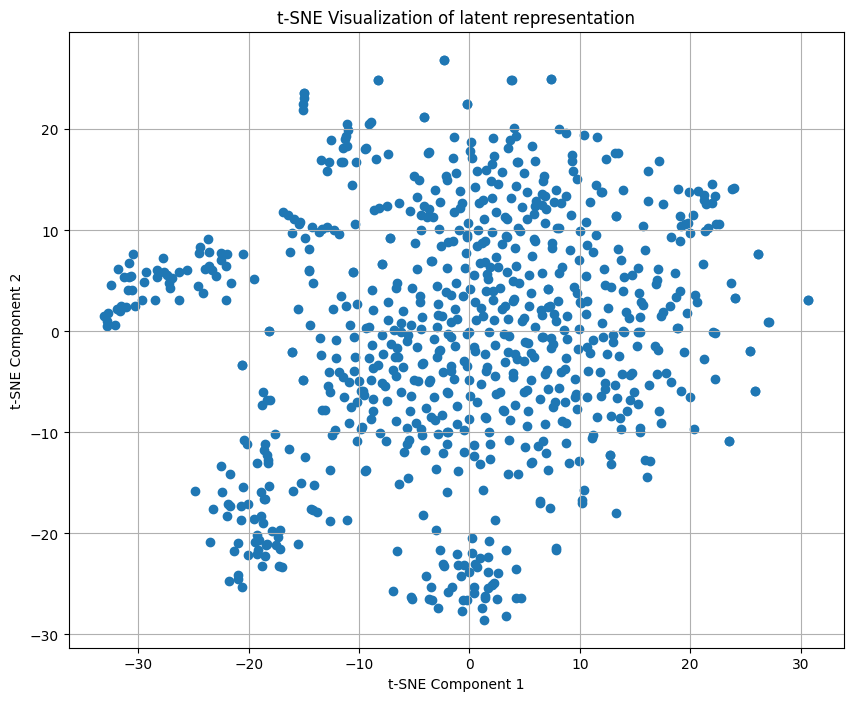

In [50]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(out_dict_camus['all_z'])

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.title('t-SNE Visualization of latent representation')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.show()

## Generation

seed set


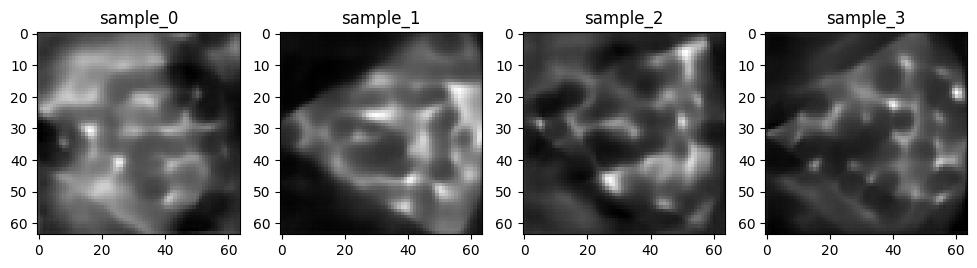

In [53]:
from cs230.autoencoder import sample
samples = sample(model, num_samples=4, latent_dim=args.latent_dim,
                 device=args.device, seed=230)

visu.show_save_imgs(samples, save=False, save_path=None, s=3)

# Encode SUMAC

In [18]:
from cs230.data import load_SUMAC_dataset
dataset_dir = "../dataset/sumac_256/"
sumac_dataset_d = load_SUMAC_dataset(dataset_dir, img_size=64, return_paths=True,
                                    extension="nii.gz",random_state=42)

X = sumac_dataset_d['X']
y = sumac_dataset_d['y']
X.shape, y.shape

100%|██████████| 1000/1000 [00:06<00:00, 159.04it/s]



*** Image intensity values divided by 255 ***



100%|██████████| 1000/1000 [00:04<00:00, 249.77it/s]


3


(torch.Size([1000, 1, 64, 64]), torch.Size([1000, 3, 64, 64]))

In [19]:
class sumacDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_dict = {'image': self.data[index]}
        return data_dict

shuffle = False
assert not shuffle,"Do not shuffle when creating dataloader to ensure consistency"
sumac_dataset = sumacDataset(X)
sumac_loader = DataLoader(dataset=sumac_dataset, batch_size=args.batch_size,
                          shuffle=shuffle)

all_imgs = [batch['image'] for batch in sumac_loader]
all_imgs = torch.cat(all_imgs, dim=0)
torch.equal(all_imgs, X) # True

True

ix = 43
(64, 64)
1.0 0.0


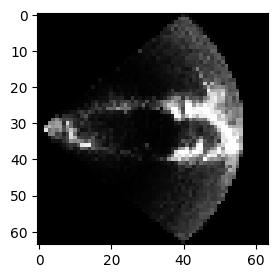

In [20]:
# Show an image
x = next(iter(sumac_loader))
ix = np.random.choice(len(x['image']))
print(f'ix = {ix}')
img = x['image'].detach().cpu().numpy().squeeze()[ix]
print(img.shape)
print(img.max(),  img.min())
plt.figure(figsize=(3,3))
plt.imshow(img,cmap='gray')

## Inference SUMAC

In [21]:
loader = sumac_loader

##############################################################################

out_dict_sumac = predict(loader, model, args)

avg_mu_sumac = np.mean(out_dict_sumac['all_mu'], axis=0)
print(f'avg_mu_sumac shape  : {avg_mu_sumac.shape}')

all_var_sumac = np.exp(out_dict_sumac['all_logvar'])
avg_var_sumac = np.mean(all_var_sumac, axis=0)
print(f'avg_var_sumac shape : {avg_var_sumac.shape}')

print('\nAverage l1 error : ')
print(np.abs(avg_mu_sumac- 0).mean())
print(np.abs(avg_var_sumac- 1).mean())

100%|██████████| 16/16 [00:00<00:00, 32.55it/s]

avg_mu_sumac shape  : (256,)
avg_var_sumac shape : (256,)

Average l1 error : 
0.2947352
0.86033237


In [22]:
np.all(out_dict_sumac['all_imgs'] == X.detach().cpu().numpy())

True

In [23]:
n_picked_sumac = 1000
show_tsne = False
show_imgs = False

#################################

all_z_camus = out_dict_camus['all_z']
all_z_sumac = out_dict_sumac['all_z']

# np.random.seed(42)
# replace=False !!!!!!!!!!
# ixs = np.random.choice(len(all_z_sumac), n_picked_sumac,replace=False)

picked_z_sumac = all_z_sumac  # [ixs]
picked_imgs_sumac = out_dict_sumac['all_imgs'] # [ixs]
sumac_camus_z = np.concatenate((picked_z_sumac, all_z_camus), axis=0)
print(f'sumac_camus_z shape : {sumac_camus_z.shape}')

# Show picked images
if show_imgs:
    titles = [f'img_{k}' for k in ixs]
    visu.show_images(picked_imgs_sumac, s=3, cs=5, titles=titles)

# Visualization latent space
if show_tsne:
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(sumac_camus_z)

    plt.figure()
    plt.scatter(X_tsne[:n_picked_sumac, 0], X_tsne[:n_picked_sumac, 1],color='r')
    plt.scatter(X_tsne[n_picked_sumac:, 0], X_tsne[n_picked_sumac:, 1])
    plt.title('t-SNE Visualization of latent representation CAMUS and SUMAC')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(['SUMAC','CAMUS'])
    plt.grid()
    plt.show()

sumac_camus_z shape : (1800, 256)


## Outlier identification by Distance Mahalanobis

<font color='red'>**How should we calculate `cov_z_camus` ?**

In [24]:
from scipy.spatial.distance import mahalanobis

avg_z_camus = np.mean(all_z_camus, axis=0)
# cov_z_camus = np.diag(avg_var_camus)
cov_z_camus = np.cov(all_z_camus, rowvar=False)

cov_z_camus_inv = np.linalg.inv(cov_z_camus)
print(f'avg_z_camus shape    : {avg_z_camus.shape}')
print(f'cov_z_camus shape    : {cov_z_camus.shape}\n')

# MD_camus
MD_camus = [mahalanobis(z_c, avg_z_camus, cov_z_camus_inv) for z_c in all_z_camus]
MD_camus = np.array(MD_camus)
utils.log('MD_camus', MD_camus)
avg_MD_camus = MD_camus.mean()
print(f'Average MD of Camus : {avg_MD_camus}\n')

# MD_SUMAC
MD_sumac = [mahalanobis(z_s, avg_z_camus, cov_z_camus_inv) for z_s in picked_z_sumac]
MD_sumac = np.array(MD_sumac)
utils.log('MD_sumac', MD_sumac)

avg_z_camus shape    : (256,)
cov_z_camus shape    : (256, 256)

MD_camus                 shape: (800,)                min:   11.66047  max:   21.08692  float64
Average MD of Camus : 15.89171457850332

MD_sumac                 shape: (1000,)               min:   16.67421  max:   27.01694  float64



*** MD_camus shapiro test ***

Null hypothesis                : data was drawn from a normal distribution.
Shapiro-Wilk Test Statistic    : 0.989 (Normal law if it is smaller but close to 1)
alpha                          : 0.05
p-value                        : 0.000

The data does not follow a Gaussian distribution (significant)

----------------------------------------------------------------

*** MD_sumac shapiro test ***

Null hypothesis                : data was drawn from a normal distribution.
Shapiro-Wilk Test Statistic    : 0.994 (Normal law if it is smaller but close to 1)
alpha                          : 0.05
p-value                        : 0.000

The data does not follow a Gaussian distribution (significant)


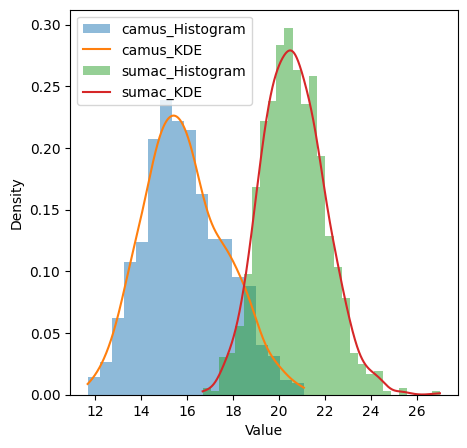

In [25]:
# Show MD distribution
fig, ax = plt.subplots(figsize=(5,5))
visu.plot_hist_with_kde(MD_camus, ax=ax, label_prefix='camus', show_hist=True)
visu.plot_hist_with_kde(MD_sumac, ax=ax, label_prefix='sumac',show_hist=True)

# Shapiro tests
print('\n*** MD_camus shapiro test ***\n')
utils.interpreate_shapiro_test(MD_camus)
print('\n----------------------------------------------------------------')
print('\n*** MD_sumac shapiro test ***\n')
utils.interpreate_shapiro_test(MD_sumac)

In [26]:
# def get_outliers_from_MD(MD, PERC_THRE=99):
#     """
#     MD : Mahalanobis distance, 1d numpy array
#     """
#     percentile_value = np.percentile(MD, PERC_THRE)
#     outlier_ixs = np.where(MD >= percentile_value)[0]
    

(10, 1, 64, 64)


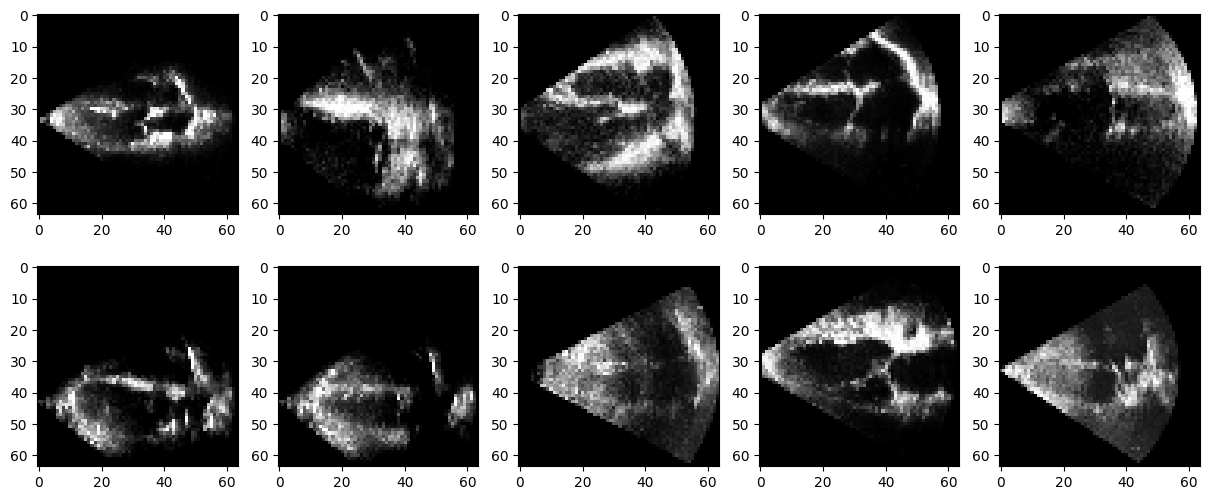

In [28]:
PERC_THRE = 99 # percentile threshold

percentile_value = np.percentile(MD_sumac, PERC_THRE)
outlier_ixs = np.where(MD_sumac >= percentile_value)[0]

outlier_imgs = picked_imgs_sumac[outlier_ixs]
print(outlier_imgs.shape)

visu.show_images(outlier_imgs, s=3, cs=5)

In [30]:
X_arr = X.detach().cpu().numpy()
np.all(X_arr[outlier_ixs] == outlier_imgs)

True

In [31]:
outlier_ixs

array([ 61,  99, 207, 217, 332, 576, 719, 796, 839, 912], dtype=int64)

In [32]:
outlier_paths = [sumac_dataset_d['image_paths'][ix] for ix in outlier_ixs]
outlier_label_paths = [sumac_dataset_d['label_paths'][ix] for ix in outlier_ixs]

outlier_imgs_ = data.ReadImagesNIIGZ(outlier_paths, (args.IMG_SIZE, args.IMG_SIZE), crop=None)
outlier_imgs_ = np.moveaxis(outlier_imgs_,-1,1) # move channel axis to the second positioin
outlier_imgs_ = np.moveaxis(outlier_imgs_,-1,-2)

np.all(outlier_imgs_ == outlier_imgs)

100%|██████████| 10/10 [00:00<00:00, 218.65it/s]


*** Image intensity values divided by 255 ***



True

In [35]:

file_path = "./outlier_label_paths.txt"

# Open the file in write mode
with open(file_path, "w") as file:
    # Write each string in the list to the file
    for string in outlier_label_paths:
        file.write(string + "\n")

print(f"List of strings saved to {file_path}")


List of strings saved to ./outlier_label_paths.txt


(10, 1, 64, 64)


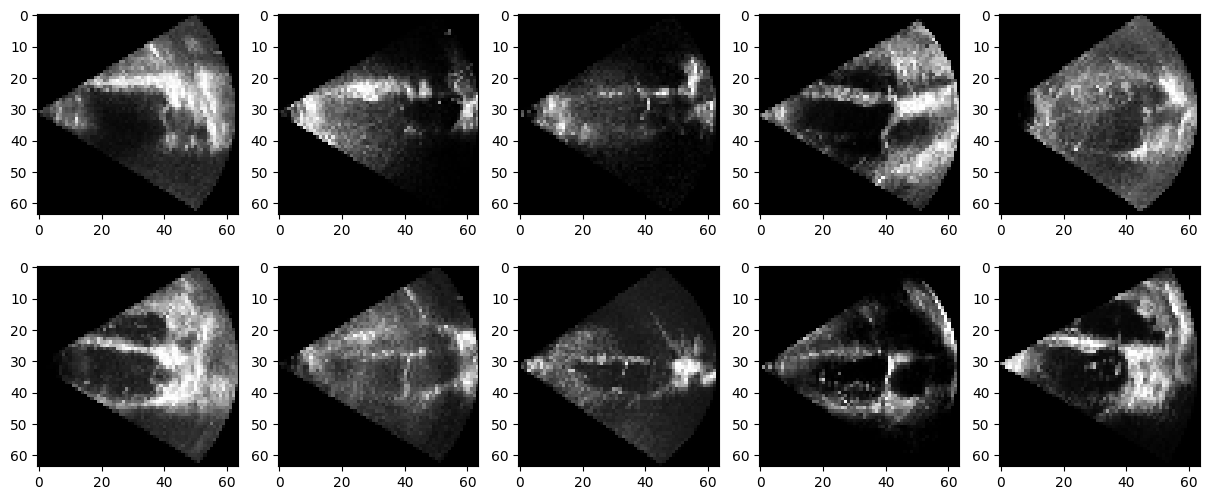

In [125]:
percentile_value = np.percentile(MD_sumac, 100 - PERC_THRE)
close_ixs = np.where(MD_sumac <= percentile_value)[0]

close_imgs = picked_imgs_sumac[close_ixs]
print(close_imgs.shape)

visu.show_images(close_imgs, s=3, cs=5)

(8, 1, 64, 64)


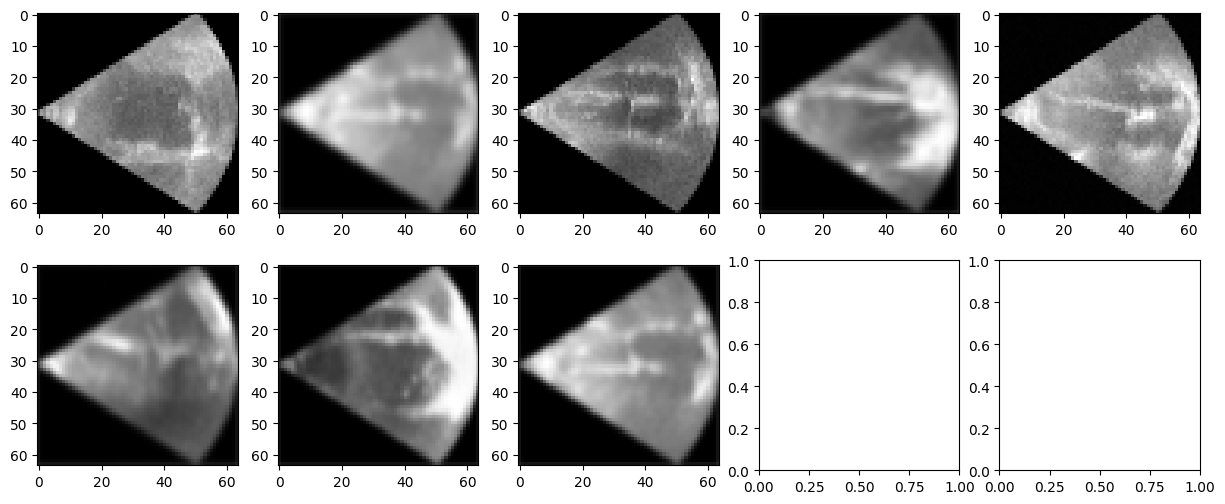

In [39]:
# Examine the CAMUS dataset
PERC_THRE = 99 # percentile threshold

percentile_value = np.percentile(MD_camus, 100-PERC_THRE)
ixs = np.where(MD_camus < percentile_value)[0]

outlier_imgs_c = out_dict_camus['all_imgs'][ixs]
print(outlier_imgs_c.shape)

visu.show_images(outlier_imgs_c, s=3, cs=5)

## Show reconstruction

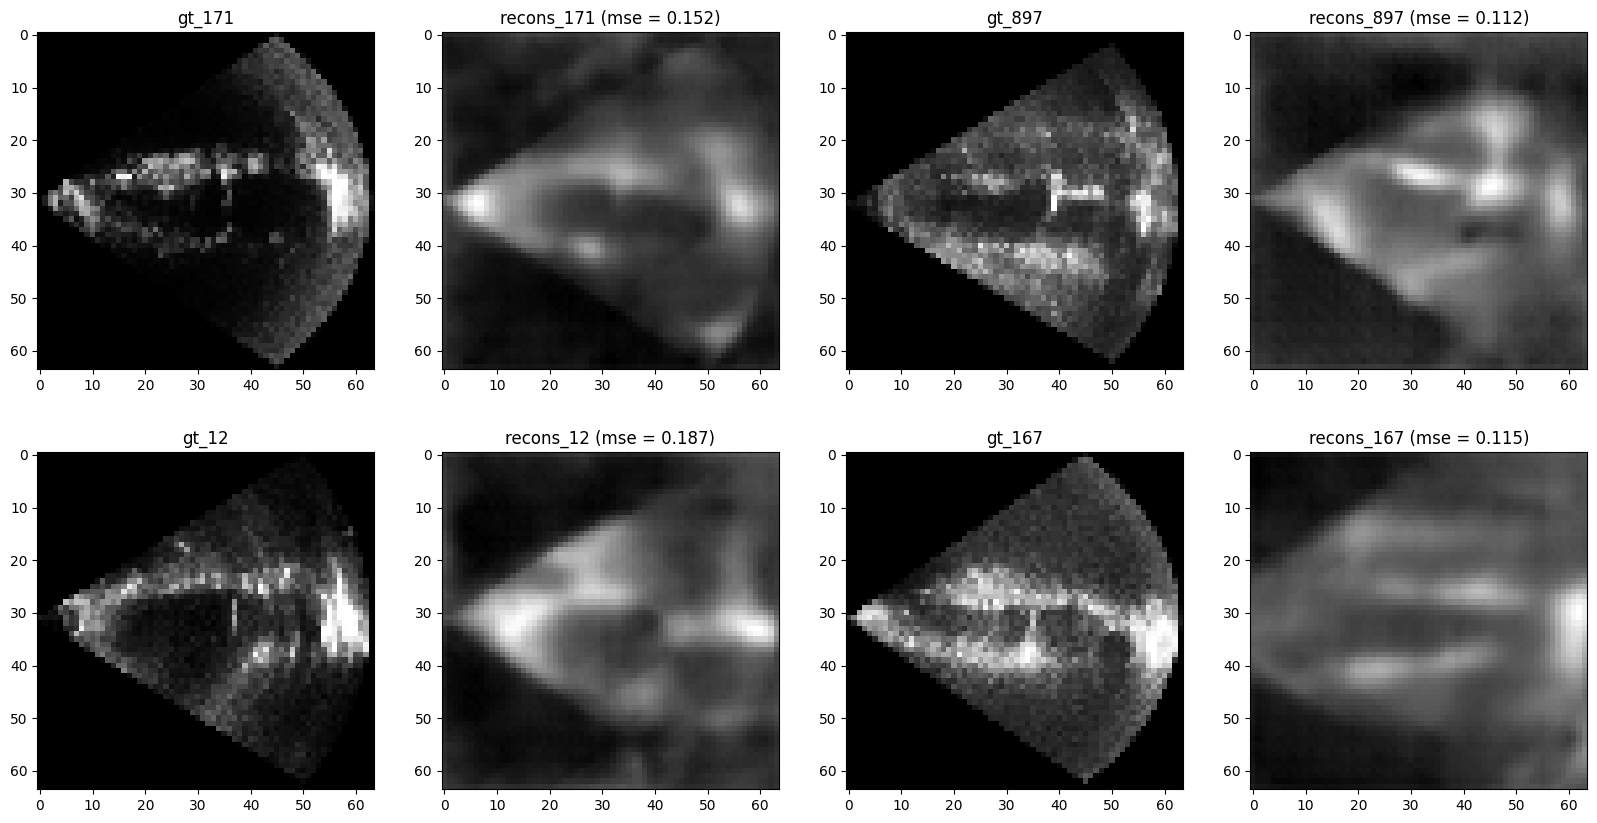

In [22]:
from cs230.visu import show_reconstruction
show_reconstruction(out_dict['all_imgs'], out_dict['all_x_hat'], nb_picked=4, 
                    random_show=True, save=False)

# Nathan implementation

In [29]:
from cs230.autoencoder import VariationalAutoencoder2d

In [30]:
model = VariationalAutoencoder2d(args.input_shape, args.blocks, args.init_channels,
                                 args.latent_dim, activation=args.activation,
                                 use_batchnorm=args.use_batchnorm)

In [31]:
from torchinfo import summary

# # Print the summary of the network
summary_kwargs = dict(
   col_names = ["input_size", "output_size", "num_params"],
   depth = 4,
   verbose = 0,
)
input_shape = (10, 1, args.IMG_SIZE, args.IMG_SIZE)
summary(model, input_shape, **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
VariationalAutoencoder2d                      [10, 1, 64, 64]           [10, 256]                 --
├─Encoder2d: 1-1                              [10, 1, 64, 64]           [10, 256]                 --
│    └─Sequential: 2-1                        [10, 1, 64, 64]           [10, 64, 4, 4]            --
│    │    └─Sequential: 3-1                   [10, 1, 64, 64]           [10, 64, 32, 32]          --
│    │    │    └─Conv2d: 4-1                  [10, 1, 64, 64]           [10, 64, 32, 32]          640
│    │    │    └─ELU: 4-2                     [10, 64, 32, 32]          [10, 64, 32, 32]          --
│    │    │    └─BatchNorm2d: 4-3             [10, 64, 32, 32]          [10, 64, 32, 32]          128
│    │    └─Sequential: 3-2                   [10, 64, 32, 32]          [10, 64, 32, 32]          --
│    │    │    └─Conv2d: 4-4                  [10, 64, 32, 32]          [10, 64, 32,